#### Experiment Description

- Experiment name: new design of live button on the Android platform 
- Experiment duration: from May 10th 2023 to May 21th 2023
- Current button usage:the current version of app for Android platform features live button, which is used as a selector of live (active) matches in any given sport that the user is currently looking at. 

Image on the left depicts start screen before clicking on the live button, and image to the right depicts start screen after clicking on the live button.

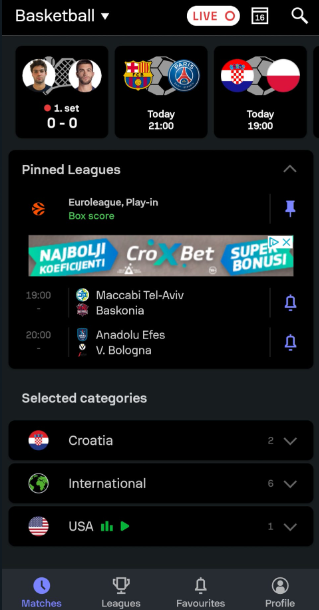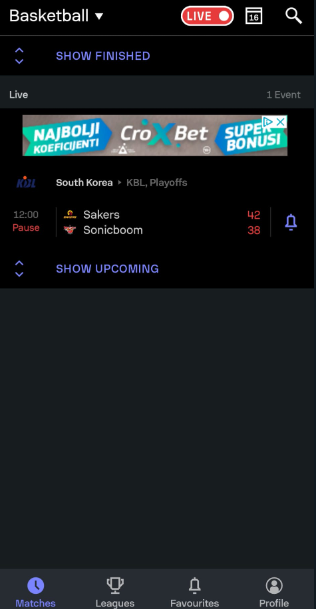

WHY would the live button be modified :
- there could be assumption that the current button is not calling users to action and furthermore that the user is unaware of the possibility of using the button to effectively gain the information about the current matches. That assumption could be correct not only by looking at the clicks on the live button, but also by looking at the number of clicks and searches on other parts on the platform that would have the same result. For instance, users could be unaware of the possibility of using the live button and are using some cycle, like this imaginary one,to achieve the same results : click on sport -> click on matches -> click on matches today-> select matches played now. This could make imaginary user uncomfortable using the app, since there wouldn't be any straightforward way of achieving desired functionality.
- another assumption could be, for instance, that the color of the button is too passive and users are not using the button since it merged with background and other elements of the app, which would be harmful if our aim is to achieve seamless usage. 

HOW could it be modified:
   - change of the color
   - change of the button position
   - change of the information flow (how the user goes through the site)
   - change of the page layout (effectively changing one more thing in the page layout other than the button position, for instance swapping two buttons)

One of the decisions to make to conduct this A/B testing is to select the platform and number of users that'll be selected for this A/B testing, but the task is formed as though the platform is chosen (Android) and users had been selected (directly since the data used here was obtained by querying on a table in the database).

#### Data loading 

In [27]:
from scipy import stats
import pandas as pd
import numpy as np 

In [28]:
DATA_PATH = "./data.csv"


In [29]:
experiment_data = pd.read_csv(DATA_PATH)
print(experiment_data.columns)
experiment_data.head()

C:\Temp\ipykernel_27140\371164199.py:1: DtypeWarning: Columns (9,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  experiment_data = pd.read_csv(DATA_PATH)


Index(['event_date', 'event_timestamp', 'event_name', 'user_pseudo_id',
       'geo_country', 'app_info_version', 'platform', 'firebase_experiments',
       'id', 'item_name', 'previous_first_open_count', 'name', 'event_id',
       'status'],
      dtype='object')


,event_date,event_timestamp,event_name,user_pseudo_id,geo_country,app_info_version,platform,firebase_experiments,id,item_name,previous_first_open_count,name,event_id,status
0,20230521,1684695366777000,add_favorite_event,db8362afafad9008b306e16cb74b23f9,Germany,6.11.4,ANDROID,['firebase_exp_61_0'],10388353.0,NaN,NaN,NaN,NaN,NaN
1,20230521,1684688348875003,add_favorite_event,1706376bf827297558e9b7e40a98deaa,Montenegro,6.11.4,ANDROID,"['firebase_exp_62_1', 'firebase_exp_61_0']",10411531.0,NaN,NaN,NaN,NaN,NaN
2,20230521,1684688357111008,add_favorite_event,1706376bf827297558e9b7e40a98deaa,Montenegro,6.11.4,ANDROID,"['firebase_exp_62_1', 'firebase_exp_61_0']",10499030.0,NaN,NaN,NaN,NaN,NaN
3,20230521,1684688361838009,add_favorite_event,1706376bf827297558e9b7e40a98deaa,Montenegro,6.11.4,ANDROID,"['firebase_exp_61_0', 'firebase_exp_62_1']",10923182.0,NaN,NaN,NaN,NaN,NaN
4,20230521,1684693313985030,add_favorite_event,1706376bf827297558e9b7e40a98deaa,Montenegro,6.11.4,ANDROID,"['firebase_exp_61_0', 'firebase_exp_62_1']",10987674.0,NaN,NaN,NaN,NaN,NaN


 Dividing users to control and treatment group

In [30]:
control_group = experiment_data[experiment_data['firebase_experiments'].apply(lambda x: 'firebase_exp_61_0' in x)]
treatment_group = experiment_data[experiment_data['firebase_experiments'].apply(lambda x: 'firebase_exp_61_1' in x)]

In [31]:
assert 'firebase_exp_61_0' not in treatment_group['firebase_experiments'], 'cannot have firebase index of control group in the treatment group'
assert 'firebase_exp_61_1' not in control_group['firebase_experiments'], 'cannot have firebase index of treatment group in the control group'

In [32]:
treatment_group = treatment_group.reset_index(drop=True)
treatment_group.head(1)



,event_date,event_timestamp,event_name,user_pseudo_id,geo_country,app_info_version,platform,firebase_experiments,id,item_name,previous_first_open_count,name,event_id,status
0,20230521,1684695505421009,add_favorite_event,c1a9b5420e378fb00655f0a2fbf5660b,Bosnia & Herzegovina,6.11.4,ANDROID,['firebase_exp_61_1'],11125134.0,NaN,NaN,NaN,NaN,NaN


In [33]:
control_group = control_group.reset_index(drop=True)
control_group.head(1)

,event_date,event_timestamp,event_name,user_pseudo_id,geo_country,app_info_version,platform,firebase_experiments,id,item_name,previous_first_open_count,name,event_id,status
0,20230521,1684695366777000,add_favorite_event,db8362afafad9008b306e16cb74b23f9,Germany,6.11.4,ANDROID,['firebase_exp_61_0'],10388353.0,NaN,NaN,NaN,NaN,NaN


In [34]:
#dropping column platform, since it is constant : Android
treatment_group = treatment_group.drop(axis=1,columns=['platform'])
control_group = control_group.drop(axis=1,columns=['platform'])


In [35]:
print(len(control_group))
print(len(treatment_group))


8376392
8394234


#### Experiment Setup 

Goal Metric - Overall Evaluation Criterion (OEC)
- Average number of live button clicks per user


Secondary Metric
- average button (all buttons compared) clicks per user
- live button feature retenion
- user retention  [DROPPED] (no users that first opened the app in the dataset) 
   - condition is that it never drops, meaning that the control group should retain higher user retention than the treatment group
   - we will look at the daily retention, as the target period is May 10th - May 21th, therefore shorter interval retention has to be considered.

Guardrail Metric 
-  number of odds impressions per user
-  number  of ads impressions per user


Statistical Tests
- tests for variance equality: Levene's test,Bartlett's test (assumes normal data distribution)
- test for the null hypothesis that 2 independent samples have identical average : Welch's T-test for the means of two independent samples of scores
- test for comparing the proportions from two populations: proportional Z-test

#### Comparing total clicks on live button in both groups, comparing average clicks on live button per user in each group

In [36]:
total_clicks_on_live_button_control_group = len(control_group[control_group['event_name'] == 'live_button'])
total_clicks_on_live_button_treatment_group = len(treatment_group[treatment_group['event_name'] == 'live_button'])


In [37]:
num_unique_users_clicked_control_group = len(control_group['user_pseudo_id'][control_group['event_name'] == 'live_button'].unique())
num_unique_users_clicked_treatment_group = len(treatment_group['user_pseudo_id'][treatment_group['event_name'] == 'live_button'].unique())

In [38]:
average_clicks_on_live_button_control_group = total_clicks_on_live_button_control_group / num_unique_users_clicked_control_group
average_clicks_on_live_button_treatment_group = total_clicks_on_live_button_treatment_group / num_unique_users_clicked_treatment_group

In [39]:
mean_difference = abs(((total_clicks_on_live_button_control_group / len(control_group)) - (total_clicks_on_live_button_treatment_group / len(treatment_group))) * 100)

In [40]:
print(f"Total clicks on live button in control group vs treatment group: {total_clicks_on_live_button_control_group} vs {total_clicks_on_live_button_treatment_group}.\n")
print(f"Average clicks per user in control group vs treatment group : {average_clicks_on_live_button_control_group}% vs {average_clicks_on_live_button_treatment_group}%.\n")
print(f"With mean percentage difference of number of clicks: {mean_difference:.6f}% between the groups,\n"
      f"but {average_clicks_on_live_button_control_group - average_clicks_on_live_button_treatment_group}% difference in average clicks on live button between groups \n"
      f"(average clicks per user in control group: {average_clicks_on_live_button_control_group}% - "
      f"average clicks per user in treatment group: {average_clicks_on_live_button_treatment_group}%).")


Total clicks on live button in control group vs treatment group: 104170 vs 117432.

Average clicks per user in control group vs treatment group : 22.53298723772442% vs 14.866691986327384%.

With mean percentage difference of number of clicks: 0.155346% between the groups,
but 7.666295251397036% difference in average clicks on live button between groups 
(average clicks per user in control group: 22.53298723772442% - average clicks per user in treatment group: 14.866691986327384%).


Performing Welch's t-test to examine if there is statistically significant difference at the significance level of 0.05 between te average clicks per user on the live button in the control and treatment group.

Setting Experiment Hypothesis

- H1 hypothesis :  there is *no* significant difference between the control and treatment average clicks on live button per user.
- H0 hypothesis : control group average clicks on live button per user is higher than treatment group average clicks on live button per user.
- significance level (alfa) : 0.05

In [41]:
H1 = "there is *no* difference between the control and treatment average clicks on live button per user"
H0 = "control group average clicks on live button per user is higher than treatment group average clicks on live button per user"

In [42]:
alfa = 0.05

Assumption of the T-test is  homoscedasticity (equal variances of all the groups).

In [43]:
control_group_users_clicks = control_group[control_group['event_name']=='live_button']['user_pseudo_id'].value_counts()
treatment_group_users_clicks = treatment_group[treatment_group['event_name']=='live_button']['user_pseudo_id'].value_counts()

In [44]:
print(f"Variance of control group vs treatment group : {np.var(control_group_users_clicks)} vs {np.var(treatment_group_users_clicks)}")

Variance of control group vs treatment group : 2806.6058229388377 vs 1672.035020466085


In [45]:
stat, p_value = stats.bartlett(control_group_users_clicks, treatment_group_users_clicks)
print(f"Bartlett's test statistic: {stat}, P-value: {p_value}")

Bartlett's test statistic: 405.0016802461053, P-value: 4.488987697843792e-90


In [46]:
stat, p_value = stats.levene(control_group_users_clicks, treatment_group_users_clicks)
print(f"Levene's test statistic: {stat}, P-value: {p_value}")


Levene's test statistic: 70.69688367868265, P-value: 4.6138416638182894e-17


Conclusion is that the variances are not equal at significance level alfa=0.05, since Levene and Bartlett's test return lower p-value, therefore Welch's t-test will be used (thus setting equal_var to false).
This is two-sided test (looking if averages differ anyhow).

In [47]:
statistic, pvalue = stats.ttest_ind(control_group_users_clicks, treatment_group_users_clicks,equal_var=False,alternative = 'less')

In [48]:
if pvalue < alfa:
    print(f"p-value is : {pvalue:.6e}, which at our significance level alfa={alfa} means we must accept alternative hypothesis H1.")
    print(f"H1 : {H1}")
else:
    print(f"p-value is : {pvalue:.6e}, which at our significance level alfa={alfa} means we cannot reject the H0 hypothesis.")
    print(f"H0 : {H0}")

p-value is : 1.000000e+00, which at our significance level alfa=0.05 means we cannot reject the H0 hypothesis.
H0 : control group average clicks on live button per user is higher than treatment group average clicks on live button per user


Preliminary results show us there is statistically significant difference between mean average clicks per user in control in treatment group. Now, I want to see why is that the case; before assigning any conclusion to this test's results, I will conduct analysis to check retention rate between users in both groups, number of clicks on other buttons (maybe new buttons' position complicated user flow through website or previous design had alternative way of reaching live results without actually clicking on the live button).

#### Retention

Cohort
   - here defined by the users that interacted with the live button
   - expectation is that the size of the cohort group is going to differ between users in control and treatment group that interact with the live button, which number is going to be commented in the part of feature discovery, where total users that interacted with the live button are subject of interest

Live button retention 
   - defined as: how long had the people been interacting with the live button after initial discovery of the live button.
   

In [49]:
print(control_group['event_name'].unique())

['add_favorite_event' 'ads_impression_custom' 'drawer_action' 'event_vote'
 'follow_league' 'follow_player' 'follow_team' 'live_button'
 'odds_impression' 'open_event' 'open_league' 'open_player' 'open_team'
 'unfollow_league' 'unfollow_player' 'unfollow_team']


In [50]:
print(treatment_group['event_name'].unique())

['add_favorite_event' 'ads_impression_custom' 'drawer_action' 'event_vote'
 'follow_league' 'follow_player' 'follow_team' 'live_button'
 'odds_impression' 'open_event' 'open_league' 'open_player' 'open_team'
 'unfollow_league' 'unfollow_player' 'unfollow_team']


From above code it is obvious that in this period there was no event named 'first_open', which indicates that the user used the app for the first time. This is a major issue,as I can no calculate the retention without having this information. Therefore, I will be looking at other metrics:  in this case I will be exploring how many people in both groups had been using actively that button (activity would be defined on daily basis, where if user clicked on live button in a day, he'd be characterized as active in that day).

##### Live button user retention 

In [51]:
def calculate_continuous_days(group):
    group = group.sort_values('event_date')
    group['previous_date'] = group['event_date'].shift(1)
    group['days_difference'] = (group['event_date'] - group['previous_date']).dt.days
    group['continuous'] = group['days_difference'] == 1
    return group



In [52]:
startdate = control_group['event_date'].min()
startdate = pd.to_datetime(startdate, format='%Y%m%d',yearfirst=True)
startdate

Timestamp('2023-05-10 00:00:00')

In [53]:
user_pseudo_ids_control_group = control_group[control_group['event_name']=='live_button']

In [54]:
user_pseudo_ids_control_group['event_date'] = pd.to_datetime(user_pseudo_ids_control_group['event_date'].copy(), format='%Y%m%d', yearfirst=True)
user_pseudo_ids_control_group = user_pseudo_ids_control_group.groupby('user_pseudo_id').apply(calculate_continuous_days)

user_pseudo_ids_control_group.reset_index(drop=True, inplace=True)

C:\Temp\ipykernel_27140\4006445456.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_pseudo_ids_control_group['event_date'] = pd.to_datetime(user_pseudo_ids_control_group['event_date'].copy(), format='%Y%m%d', yearfirst=True)


In [55]:
first_activity_date = user_pseudo_ids_control_group.groupby('user_pseudo_id')['event_date'].min().rename('first_activity_date')

user_pseudo_ids_control_group = user_pseudo_ids_control_group.merge(first_activity_date, on='user_pseudo_id')
user_pseudo_ids_control_group['days_after_first_activity'] = (user_pseudo_ids_control_group['event_date'] - user_pseudo_ids_control_group['first_activity_date']).dt.days

retention_by_day_control_group = user_pseudo_ids_control_group.groupby('days_after_first_activity').agg(total_active_users=('user_pseudo_id', 'nunique')).reset_index()
total_users_control_group = user_pseudo_ids_control_group['user_pseudo_id'].nunique()
retention_by_day_control_group['retention_rate'] = (retention_by_day_control_group['total_active_users'] / total_users_control_group) * 100

In [56]:
print(retention_by_day_control_group[['days_after_first_activity', 'total_active_users', 'retention_rate']])

    days_after_first_activity  total_active_users  retention_rate
0                           0                4623      100.000000
1                           1                1857       40.168722
2                           2                1495       32.338308
3                           3                1358       29.374865
4                           4                1223       26.454683
5                           5                1053       22.777417
6                           6                 904       19.554402
7                           7                 854       18.472853
8                           8                 591       12.783907
9                           9                 225        4.866970
10                         10                 107        2.314514
11                         11                   4        0.086524


In [57]:
user_pseudo_ids_treatment_group = treatment_group[treatment_group['event_name']=='live_button'] 

In [58]:
user_pseudo_ids_treatment_group['event_date'] = pd.to_datetime(user_pseudo_ids_treatment_group['event_date'], format='%Y%m%d', yearfirst=True)
user_pseudo_ids_treatment_group = user_pseudo_ids_treatment_group.groupby('user_pseudo_id').apply(calculate_continuous_days)

user_pseudo_ids_treatment_group.reset_index(drop=True, inplace=True)

C:\Temp\ipykernel_27140\3656442205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_pseudo_ids_treatment_group['event_date'] = pd.to_datetime(user_pseudo_ids_treatment_group['event_date'], format='%Y%m%d', yearfirst=True)


In [59]:
first_activity_date = user_pseudo_ids_treatment_group.groupby('user_pseudo_id')['event_date'].min().rename('first_activity_date')

user_pseudo_ids_treatment_group = user_pseudo_ids_treatment_group.merge(first_activity_date, on='user_pseudo_id')
user_pseudo_ids_treatment_group['days_after_first_activity'] = (user_pseudo_ids_treatment_group['event_date'] - user_pseudo_ids_treatment_group['first_activity_date']).dt.days

retention_by_day_treatment_group = user_pseudo_ids_treatment_group.groupby('days_after_first_activity').agg(total_active_users=('user_pseudo_id', 'nunique')).reset_index()
total_users_treatment_group = user_pseudo_ids_treatment_group['user_pseudo_id'].nunique()
retention_by_day_treatment_group['retention_rate'] = (retention_by_day_treatment_group['total_active_users'] / total_users_treatment_group) * 100

In [60]:
print(retention_by_day_treatment_group[['days_after_first_activity', 'total_active_users', 'retention_rate']])

    days_after_first_activity  total_active_users  retention_rate
0                           0                7899      100.000000
1                           1                2183       27.636410
2                           2                1724       21.825548
3                           3                1519       19.230282
4                           4                1382       17.495886
5                           5                1185       15.001899
6                           6                1019       12.900367
7                           7                 980       12.406634
8                           8                 690        8.735283
9                           9                 241        3.051019
10                         10                  95        1.202684
11                         11                   4        0.050639


In [61]:
merged_retention_data = pd.merge(
   retention_by_day_treatment_group,
   retention_by_day_control_group,
   on='days_after_first_activity',
   how='outer',
   suffixes=('_treatment_group','_control_group')
)

In [62]:
merged_retention_data['percentage_difference'] = merged_retention_data['retention_rate_control_group'] - merged_retention_data['retention_rate_treatment_group']

In [63]:
merged_retention_data

,days_after_first_activity,total_active_users_treatment_group,retention_rate_treatment_group,total_active_users_control_group,retention_rate_control_group,percentage_difference
0,0,7899,100.000000,4623,100.000000,0.000000
1,1,2183,27.636410,1857,40.168722,12.532312
2,2,1724,21.825548,1495,32.338308,10.512761
3,3,1519,19.230282,1358,29.374865,10.144582
4,4,1382,17.495886,1223,26.454683,8.958798
5,5,1185,15.001899,1053,22.777417,7.775518
6,6,1019,12.900367,904,19.554402,6.654035
7,7,980,12.406634,854,18.472853,6.066219
8,8,690,8.735283,591,12.783907,4.048624
9,9,241,3.051019,225,4.866970,1.815950


In [64]:
merged_retention_data[merged_retention_data['days_after_first_activity']==1]['retention_rate_treatment_group'].iloc[0]

27.636409672110396

In [65]:
print(f"In control group there is {control_group['user_pseudo_id'].nunique()} unique users, and in treatment group there is {treatment_group['user_pseudo_id'].nunique()} unique users.")
print(f"Users that used live button in control groups:  {(user_pseudo_ids_control_group['user_pseudo_id'].nunique())} vs in treatment group {(user_pseudo_ids_treatment_group['user_pseudo_id'].nunique())}.")
print(f"Percentage wise, {(user_pseudo_ids_control_group['user_pseudo_id'].nunique())/control_group['user_pseudo_id'].nunique()*100}% of users in control group used live_button, vs {(user_pseudo_ids_treatment_group['user_pseudo_id'].nunique())/treatment_group['user_pseudo_id'].nunique()*100}% in treatment group.")
print(f"D1 retention rate in control group  vs treatment group : {merged_retention_data[merged_retention_data['days_after_first_activity']==1]['retention_rate_treatment_group'].iloc[0]}% vs {merged_retention_data[merged_retention_data['days_after_first_activity']==1]['retention_rate_control_group'].iloc[0]}%")

In control group there is 31368 unique users, and in treatment group there is 31058 unique users.
Users that used live button in control groups:  4623 vs in treatment group 7899.
Percentage wise, 14.737949502677889% of users in control group used live_button, vs 25.433060725094986% in treatment group.
D1 retention rate in control group  vs treatment group : 27.636409672110396% vs 40.16872160934458%


##### Statistical Test Conduction

Performing proportional z-test on :
- daily live button retention between groups
- total clicks on the live button between groups

In [66]:
from statsmodels.stats.proportion import proportions_ztest

D1 Live Button Retention Test 

- H0 : There is no difference in proportions (retentions) of users in control and treatment group.
- H1 : There exists difference in proportions (retentions) of users in control and treatment group.

In [67]:
count = np.array([merged_retention_data[merged_retention_data['days_after_first_activity']==1]['total_active_users_treatment_group'].iloc[0], merged_retention_data[merged_retention_data['days_after_first_activity']==1]['total_active_users_control_group'].iloc[0]])  # Number of users retained each day in each group
nobs = np.array([total_users_treatment_group,total_users_control_group])  # Total number of users each day in each group
stat, pval = proportions_ztest(count, nobs,alternative = 'two-sided')
print(f'D1 Retention Two-sided Z-test: Z = {stat:.2f}, p-value = {pval:}')


D1 Retention Two-sided Z-test: Z = -14.48, p-value = 1.69520193234234e-47


D7 Live Button Retention Test 

In [68]:
count = np.array([merged_retention_data[merged_retention_data['days_after_first_activity']==7]['total_active_users_treatment_group'].iloc[0], merged_retention_data[merged_retention_data['days_after_first_activity']==7]['total_active_users_control_group'].iloc[0]])  # Number of users retained each day in each group
nobs = np.array([total_users_treatment_group,total_users_control_group])  # Total number of users each day in each group
stat, pval = proportions_ztest(count, nobs,alternative = 'two-sided')
print(f'D7 Retention Two-sided Z-test: Z = {stat:.2f}, p-value = {pval:}')


D7 Retention Two-sided Z-test: Z = -9.27, p-value = 1.9470123333250416e-20


Conclusions: In both cases, for D1 and D7 retention there is statistically significant difference between proportions at significance level alfa, meaning we must reject the zero hypothesis that average retentions are the same. 

One sided test

- H0: D1 retention in the treatment group is less than or equal to the proportion in the control group
- H1: D1 retention in the treatment group is greather than the proportion in the control group

In [70]:
count = np.array([merged_retention_data[merged_retention_data['days_after_first_activity']==1]['total_active_users_treatment_group'].iloc[0], merged_retention_data[merged_retention_data['days_after_first_activity']==1]['total_active_users_control_group'].iloc[0]])  # Number of users retained each day in each group
nobs = np.array([total_users_treatment_group,total_users_control_group])  # Total number of users each day in each group
stat, pval = proportions_ztest(count, nobs,alternative = 'larger')
print(f'D1 Retention One-sided Z-test: Z = {stat:.2f}, p-value = {pval:}')


D1 Retention One-sided Z-test: Z = -14.48, p-value = 1.0


In [71]:
count = np.array([merged_retention_data[merged_retention_data['days_after_first_activity']==7]['total_active_users_treatment_group'].iloc[0], merged_retention_data[merged_retention_data['days_after_first_activity']==7]['total_active_users_control_group'].iloc[0]])  # Number of users retained each day in each group
nobs = np.array([total_users_treatment_group,total_users_control_group])  # Total number of users each day in each group
stat, pval = proportions_ztest(count, nobs,alternative = 'two-sided')
print(f'D7 Retention One-Sided Z-test: Z = {stat:.2f}, p-value = {pval:}')


D7 Retention One-Sided Z-test: Z = -9.27, p-value = 1.9470123333250416e-20


Conclusion: at significance level 0.05, D1 and D7 retention is statistically significantly higher in control than in the treatment group.

NOTE: There could only be conducted single test, but I refer to both (since I didn't write this task in one try), so i decided to keep both tests.

Total clicks on the live button statistical test

- H0 :The proportion of users clicking on the live button in the control group is greater than or equal to the proportion in the treatment group.
- H1 : The proportion of users clicking on the live button in the control group is less than the proportion in the treatment group.

In [72]:
count = np.array([total_users_treatment_group,total_users_control_group])  # Number of users retained each day in each group
nobs = np.array([len(treatment_group),len(control_group)])  # Total number of users each day in each group
stat, pval = proportions_ztest(count, nobs,alternative = 'smaller')
print(f'Total clicks on the live button Z-test: Z = {stat:.2f}, p-value = {pval:}') 


Total clicks on the live button Z-test: Z = 29.17, p-value = 1.0


Conclusion: 
- H0 is not rejected at significance level alpha = 0.05, meaning that there is no sufficient evidence to conclude that the proportion of users clicking on the live button in the control group is lower than the proportion in the treatment group. Instead, the data suggests that the proportion in the control group is at least as high as in the treatment group, or possibly higher.

As can be seen from the table output above and print statements just below, it is hard to compare retention rate between treatment and control group. Statistical test and live button retention rate indicate the already observable difference, but in total, there is more people discovering live button in treatment group. 

On average, people in control group had had on average more clicks on live button and the group recorded higher retention rates from the second day onwards.Looking at the D1 retention, from the original 7899 users that discovered live button, only 2183 used it for at least one day, which means 27.6% users used the button for at least one day, compared to 40.17% in control group. 

But, in control group "only" 4623 users did indeed find the live button and used it, and 1857 users continued using the button for a day. This trend continues as the retention is looked for more days, where percentage wise control group is superior, but in total number of users, treatment group prevails. 


Therefore, my conclusion for this part of analysis is that people are on average more committed to usage of the button in the old version of the app, but more people actually discover the live button in the new version, but with statistically significantly lesser percent of user actually continuing using the button after the discovery. 

#### Guardrail metrics calculation

Guardrail Metric 
-  number of odds impressions per user
-  number  of ads impressions per user

##### Number of ads impressions per user calculation

In [73]:
number_of_ads_interactions_control_group = len(control_group[control_group['event_name']=='ads_impression_custom'])
number_of_users_that_interacted_in_control_group = len(control_group[control_group['event_name']=='ads_impression_custom']['user_pseudo_id'].unique())

In [74]:
number_of_ads_interactions_treatment_group = len(treatment_group[treatment_group['event_name']=='ads_impression_custom'])
number_of_users_that_interacted_in_treatment_group = len(treatment_group[treatment_group['event_name']=='ads_impression_custom']['user_pseudo_id'].unique())

In [75]:
average_ads_impressions_control_group = number_of_ads_interactions_control_group / number_of_users_that_interacted_in_control_group

In [76]:
average_ads_impressions_treatment_group = number_of_ads_interactions_treatment_group / number_of_users_that_interacted_in_treatment_group

In [77]:
print(f"Number of ads interactions in control vs treatment group : {number_of_ads_interactions_control_group} vs {number_of_ads_interactions_treatment_group}")

Number of ads interactions in control vs treatment group : 2742687 vs 2719386


In [78]:
print(f"Average ads interactions in control vs treatment group : {average_ads_impressions_control_group} vs {average_ads_impressions_treatment_group}")

Average ads interactions in control vs treatment group : 101.18376005312477 vs 101.34105984944473


In [79]:
control_group_users_ads_impressions = control_group[control_group['event_name']=='ads_impression_custom']['user_pseudo_id'].value_counts()
treatment_group_users_ads_impressions = treatment_group[treatment_group['event_name']=='ads_impression_custom']['user_pseudo_id'].value_counts()

Procedure here is the same as the procedure in the previous test, where I was testing for statistically significant difference between average clicks on live button in each group, thus I won't explicitly state the cause and description of each part of the test, but I wil look into results.

- H0 hypothesis : average ods impressions per user is the same in control and treatment group.
- H1 hypothesis : average ads impressions per user is lees treatment group than in the control group.

In [80]:
H0 = "average ods impressions per user is the same in control and treatment group"
H1 = "average ads impressions per user is less in treatment group than in  control group"

In [81]:
alfa = 0.05

In [82]:
print(f"Variance of control group vs treatment group : {np.var(control_group_users_ads_impressions)} vs {np.var(treatment_group_users_ads_impressions)}")


Variance of control group vs treatment group : 49371.467191440104 vs 52704.372535598784


In [83]:
stat, p_value = stats.bartlett(control_group_users_ads_impressions, treatment_group_users_ads_impressions)
print(f"Bartlett's test statistic: {stat}, P-value: {p_value}")

Bartlett's test statistic: 28.76934941851317, P-value: 8.153126009400784e-08


In [84]:
stat, p_value = stats.levene(control_group_users_ads_impressions, treatment_group_users_ads_impressions)
print(f"Levene's test statistic: {stat}, P-value: {p_value}")

Levene's test statistic: 0.051842120688894454, P-value: 0.8198891608086143


In [85]:
statistic, pvalue = stats.ttest_ind(control_group_users_ads_impressions, treatment_group_users_ads_impressions,equal_var=True,alternative = 'less')

In [86]:
if pvalue < alfa:
    print(f"p-value is : {pvalue:.6e}, which at our significance level alfa={alfa} means we must accept alternative hypothesis H1.")
    print(f"H1 : {H1}")
else:
    print(f"p-value is : {pvalue:.6e}, which at our significance level alfa={alfa} means we cannot reject the H0 hypothesis.")
    print(f"H0 : {H0}")

p-value is : 4.677771e-01, which at our significance level alfa=0.05 means we cannot reject the H0 hypothesis.
H0 : average ods impressions per user is the same in control and treatment group


##### Number of odds impressions per user calculation

In [87]:
number_of_odds_interactions_control_group = len(control_group[control_group['event_name']=='odds_impression'])
number_of_users_that_interacted_in_control_group = len(control_group[control_group['event_name']=='odds_impression']['user_pseudo_id'].unique())

In [88]:
number_of_odds_interactions_treatment_group = len(treatment_group[treatment_group['event_name']=='odds_impression'])
number_of_users_that_interacted_in_treatment_group = len(treatment_group[treatment_group['event_name']=='odds_impression']['user_pseudo_id'].unique())

In [89]:
average_odds_impressions_control_group = number_of_odds_interactions_control_group / number_of_users_that_interacted_in_control_group

In [90]:
average_odds_impressions_treatment_group = number_of_odds_interactions_treatment_group / number_of_users_that_interacted_in_treatment_group

In [91]:
print(f"Number of odds interactions in control vs treatment group : {number_of_odds_interactions_control_group} vs {number_of_odds_interactions_treatment_group}")
print(f"Average odds interactions in control vs treatment group : {average_odds_impressions_control_group} vs {average_odds_impressions_treatment_group}")

Number of odds interactions in control vs treatment group : 3549521 vs 3563336
Average odds interactions in control vs treatment group : 127.62093265739043 vs 129.67959822403378


In [92]:
control_group_users_odds_impressions = control_group[control_group['event_name']=='odds_impression']['user_pseudo_id'].value_counts()
treatment_group_users_odds_impressions = treatment_group[treatment_group['event_name']=='odds_impression']['user_pseudo_id'].value_counts()

- H0 hypothesis : average ods impressions per user is the same in control and treatment group.
- H1 hypothesis : average ads impressions per user is less in the  treatment group than in the control group.

In [93]:
H0 = "average odds impressions per user is the same in control and treatment group"
H1 = "average  odds impressions per user is less in the  treatment group than in control group."


In [94]:
alfa = 0.05

In [95]:
print(f"Variance of control group vs treatment group : {np.var(control_group_users_odds_impressions)} vs {np.var(treatment_group_users_odds_impressions)}")

Variance of control group vs treatment group : 178212.2157441846 vs 289012.90433011006


In [96]:
stat, p_value = stats.bartlett(control_group_users_odds_impressions, treatment_group_users_odds_impressions)
print(f"Bartlett's test statistic: {stat}, P-value: {p_value}")

Bartlett's test statistic: 1601.5671666303263, P-value: 0.0


In [97]:
stat, p_value = stats.levene(control_group_users_odds_impressions, treatment_group_users_odds_impressions)
print(f"Levene's test statistic: {stat}, P-value: {p_value}")

Levene's test statistic: 0.28973635231693773, P-value: 0.5903916982604077


In [98]:
statistic, pvalue = stats.ttest_ind(control_group_users_odds_impressions, treatment_group_users_odds_impressions,equal_var=True,alternative = 'less')

In [99]:
if pvalue < alfa:
    print(f"p-value is : {pvalue:.6e}, which at our significance level alfa={alfa} means we must accept alternative hypothesis H1.")
    print(f"H1 : {H1}")
else:
    print(f"p-value is : {pvalue:.6e}, which at our significance level alfa={alfa} means we cannot reject the H0 hypothesis.")
    print(f"H0 : {H0}")

p-value is : 3.081486e-01, which at our significance level alfa=0.05 means we cannot reject the H0 hypothesis.
H0 : average odds impressions per user is the same in control and treatment group


Since the average and total ads/odds impressions do not differ significantly between the two groups, I can assume the following:
   - none guardrail metric has been violated.
   - average clicks on live button statistically signicificantly differ between the control and the treatment group
   - percentage wise retention rate in the control group is higher than in the treatment group
   - total users actively using live button is higher in the treatment group than in the control group
   - feuature discovery of live button is higher among the users of the treatment group 


#### Secondary Metric Calculation: Average clicks per button 

One last thing I will check are the average clicks on each button in both groups.


In [100]:
events = ['add_favorite_event','drawer_action','event_vote', 'follow_league', 'follow_player', 'follow_team','open_event', 'open_league',
       'open_player', 'open_team', 'unfollow_league', 'unfollow_player','unfollow_team']

In [101]:
for event in events:
   print(f"Average clicks on event : {event} in control vs treatment group: ")
   print(f"{len(control_group[control_group['event_name']==event]) / len(control_group[control_group['event_name']==event]['user_pseudo_id'].unique())} vs {len(treatment_group[treatment_group['event_name']==event]) / len(treatment_group[treatment_group['event_name']==event]['user_pseudo_id'].unique())}")

Average clicks on event : add_favorite_event in control vs treatment group: 


17.460293564170115 vs 17.234797935288935
Average clicks on event : drawer_action in control vs treatment group: 
2.8036006546644843 vs 2.7666392769104355
Average clicks on event : event_vote in control vs treatment group: 
6.913007908371966 vs 6.965339832114812
Average clicks on event : follow_league in control vs treatment group: 
3.1864406779661016 vs 2.468208092485549
Average clicks on event : follow_player in control vs treatment group: 
4.359183673469388 vs 3.1974248927038627
Average clicks on event : follow_team in control vs treatment group: 
2.5596330275229358 vs 2.8512252042007002
Average clicks on event : open_event in control vs treatment group: 
47.1568593733879 vs 47.92864087783874
Average clicks on event : open_league in control vs treatment group: 
9.26198292843073 vs 9.357044237035401
Average clicks on event : open_player in control vs treatment group: 
12.431351088410556 vs 12.769757768534378
Average clicks on event : open_team in control vs treatment group: 
11.502194

From these averages, four events (2 pairs actually) caught my attention:
   - average clicks on follow_league and follow_player
   - average clicks on unfollow_league and unfollow_league
which are obviously paired. I tested if there is and significant difference between the average clicks on those event between the gropus, but at the significance level of 0.05, there was no difference between the average clicks on any of the events.


#### CONCLUSIONS

C1 : There is statistically significant difference between average clicks on live button per user in control vs treatment group, with control group   users having higher average.

C2: Live button retention rate is statistically significantly higher among users in control group vs users in treatment group.

C3: Feature discovery (%) of live button is statistically significantly higher among users in treatment group vs users in control group.

C4: Total users using live button after discovery is higher among users in treatment group vs users in control group.

C5: There is *no* statistically significant difference between average adds and odds impressions per user in each group,and neither does the total number of adds and odds differ between the users.

#### FUTURE EXPERIMENT IMPROVEMENTS

I believe it would be useful to include new users in the experiment and to examine user behavior prior to this experiment. Since the treatment group consists of users who had already used the platform, they were exposed to the previous version of the live button and the app. This change could indicate that the users either did not favor the new button, the new layout, or had never been actively using the button.

The condition for this task was to use data from May 10th to May 21st, 2023. Thus, all the users in the experiment were not new users, meaning they had used the platform and tried it out before the start date of the experiment. This creates a biased group of people regarding the user interface and possibly the live button design. However, the historical data also holds information about user activity, which could be useful for our experiment. In that case, both groups' start dates would be a few days earlier, and activity could be tracked just before the transition to the new live button edition.

Including new users could be a valuable addition to the experiment, as their unbiased opinions toward the user interface could be valuable when collecting information about live button clicks and retention rates. This approach could help determine whether users found the live button easy to find and use.

#### Summary 

Summary of Findings

1. Click Behavior:
- There is a statistically significant difference in the average number of live button clicks per user between the control and treatment groups. Users in the control group clicked the live button more frequently on average.

2. Retention Rates:
- The live button retention rate is significantly higher in the control group compared to the treatment group. This indicates that, percentage-wise, more users continued using the live button in the control group after initially discovering it.
- However, in absolute numbers, more users in the treatment group discovered and initially used the live button, showing a higher feature discovery rate.

3. Guardrail Metrics:
- There is no statistically significant difference in the average or total number of odds and ads impressions per user between the groups, suggesting that the changes in the experiment did not adversely affect these metrics.

4. Additional Observations:
- Despite higher discovery rates in the treatment group, the proportion of users who continued to use the live button after discovery was significantly lower compared to the control group.
- No statistically significant difference was found in the clicks on related paired events (follow/unfollow league and player) between the groups.

Conclusions
- The control group demonstrated both a higher engagement with the live button and better retention over time, indicating that users were more committed to using the live button in its old format.
- The treatment group, while having more users discover the live button (possibly due to the new layout or visibility improvements), did not see the same level of continued use, suggesting that the new design may not have been as effective in retaining user engagement.
- The lack of significant differences in ads and odds impressions implies that the experiment did not impact these guardrail metrics, which is positive in terms of not negatively affecting user exposure to advertisements or odds.
